In [23]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df=pd.read_csv("heart_data.csv")
df.head(5)

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
#Checking for any null values
print(df.isnull().sum())

index          0
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [15]:
#Converting age in days to age in yrs
df['age'] = np.floor(df['age'] / 365.25).astype(int)
#Creating BMI column using existing weight(Kg) and height(cm) column
df['BMI'] = df['weight'] / ((df['height']/100) ** 2)

df.head(5)

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Hypertension,BMI
0,0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,Hypertension Stage 1,21.967120
1,1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,Hypertension Stage 2,34.927679
2,2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,Hypertension Stage 1,23.507805
3,3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,Hypertension Stage 2,28.710479
4,4,4,47,1,156,56.0,100,60,1,1,0,0,0,0,Normal,23.011177


In [ ]:
#Checking for neg values in datasets
def check_neg(column_to_check):
  negative_count = (df[column_to_check] < 0).sum()
  print("Count of negative values in column '{}': {}".format(column_to_check, negative_count))

for col in df.columns:
  check_neg(col)

Count of negative values in column 'index': 0
Count of negative values in column 'id': 0
Count of negative values in column 'age': 0
Count of negative values in column 'gender': 0
Count of negative values in column 'height': 0
Count of negative values in column 'weight': 0
Count of negative values in column 'ap_hi': 7
Count of negative values in column 'ap_lo': 1
Count of negative values in column 'cholesterol': 0
Count of negative values in column 'gluc': 0
Count of negative values in column 'smoke': 0
Count of negative values in column 'alco': 0
Count of negative values in column 'active': 0
Count of negative values in column 'cardio': 0
Count of negative values in column 'BMI': 0


In [ ]:
#sorting the df acc to age
df.sort_values(by='age', ascending=True, inplace=True)

#interpolate the negative ap_lo and ap_high with previous person who has similar age
df['ap_lo'] = df['ap_lo'].mask(df['ap_lo'] < 0, other=pd.NA)
df['ap_hi'] = df['ap_hi'].mask(df['ap_hi'] < 0, other=pd.NA)

df['ap_lo'] = df.groupby('age')['ap_lo'].transform(lambda x: x.interpolate(method='nearest'))
df['ap_hi'] = df.groupby('age')['ap_hi'].transform(lambda x: x.interpolate(method='nearest'))


for col in df.columns:
  check_neg(col)

Count of negative values in column 'index': 0
Count of negative values in column 'id': 0
Count of negative values in column 'age': 0
Count of negative values in column 'gender': 0
Count of negative values in column 'height': 0
Count of negative values in column 'weight': 0
Count of negative values in column 'ap_hi': 0
Count of negative values in column 'ap_lo': 0
Count of negative values in column 'cholesterol': 0
Count of negative values in column 'gluc': 0
Count of negative values in column 'smoke': 0
Count of negative values in column 'alco': 0
Count of negative values in column 'active': 0
Count of negative values in column 'cardio': 0
Count of negative values in column 'BMI': 0


In [ ]:
#unique value
print(df.nunique())

index          70000
id             70000
age               28
gender             2
height           109
weight           287
ap_hi            148
ap_lo            156
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
BMI             3808
dtype: int64


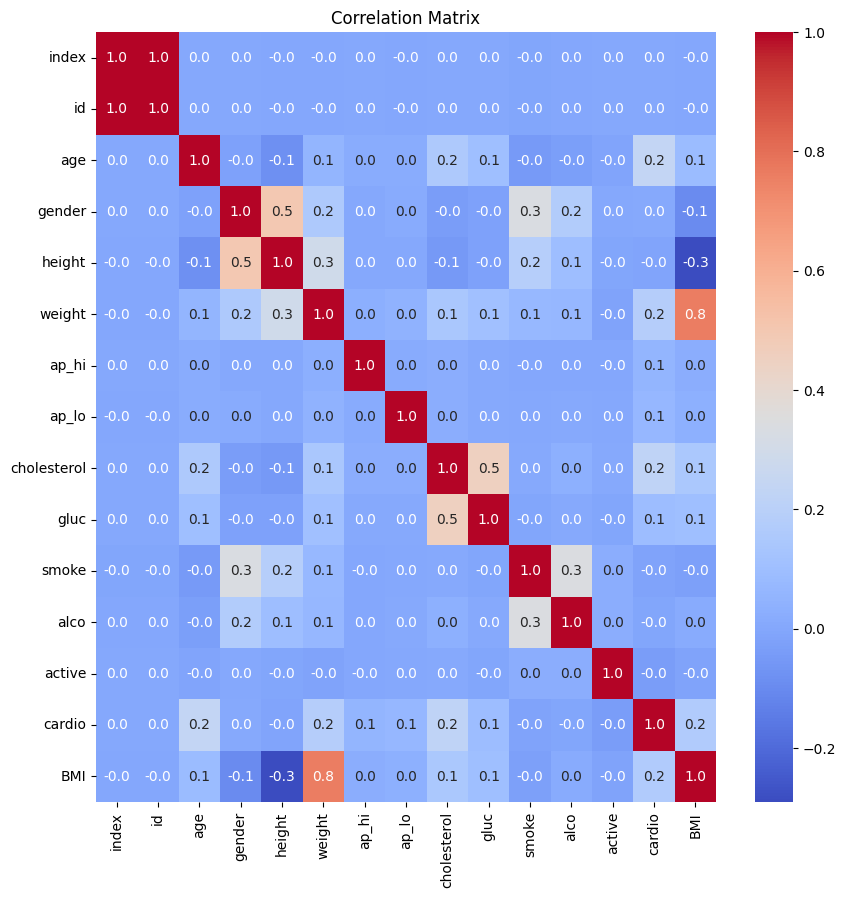

In [ ]:
#Creating correlation matrix to measure statistical dependence of each feature.
correlation_matrix = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Matrix')
plt.show()

In [30]:
# Normal:

# Systolic: Less than 120 mmHg
# Diastolic: Less than 80 mmHg
# (e.g., 115/75 mmHg)
# Elevated:

# Systolic: 120-129 mmHg
# Diastolic: Less than 80 mmHg
# (e.g., 125/78 mmHg)
# Hypertension Stage 1:

# Systolic: 130-139 mmHg
# Diastolic: 80-89 mmHg
# (e.g., 135/85 mmHg)
# Hypertension Stage 2:

# Systolic: 140 mmHg or higher
# Diastolic: 90 mmHg or higher
# (e.g., 145/92 mmHg)
# Hypertensive Crisis:

# Systolic: Higher than 180 mmHg
# Diastolic: Higher than 120 mmHg

#making another column for hypertension acc to the above data as hypertension is one of the major causes of heart diseases

def classify_blood_pressure(row):
    systolic = row['ap_hi']
    diastolic = row['ap_lo']

    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic <= 129 and diastolic < 80:
        return 'Elevated'
    elif 130 <= systolic <= 139 or (80 <= diastolic <= 89):
        return 'Hypertension Stage 1'
    elif systolic >= 140 or diastolic >= 90:
        return 'Hypertension Stage 2'
    elif systolic > 180 or diastolic > 120:
        return 'Hypertensive Crisis'
    else:
        return 'Unknown'  # In case of any unexpected values

# adding hypertension column
df['Hypertension'] = df.apply(classify_blood_pressure, axis=1)
print(df.head(60))

    index  id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0       0   0  18393       2     168    62.0    110     80            1     1   
1       1   1  20228       1     156    85.0    140     90            3     1   
2       2   2  18857       1     165    64.0    130     70            3     1   
3       3   3  17623       2     169    82.0    150    100            1     1   
4       4   4  17474       1     156    56.0    100     60            1     1   
5       5   8  21914       1     151    67.0    120     80            2     2   
6       6   9  22113       1     157    93.0    130     80            3     1   
7       7  12  22584       2     178    95.0    130     90            3     3   
8       8  13  17668       1     158    71.0    110     70            1     1   
9       9  14  19834       1     164    68.0    110     60            1     1   
10     10  15  22530       1     169    80.0    120     80            1     1   
11     11  16  18815       2

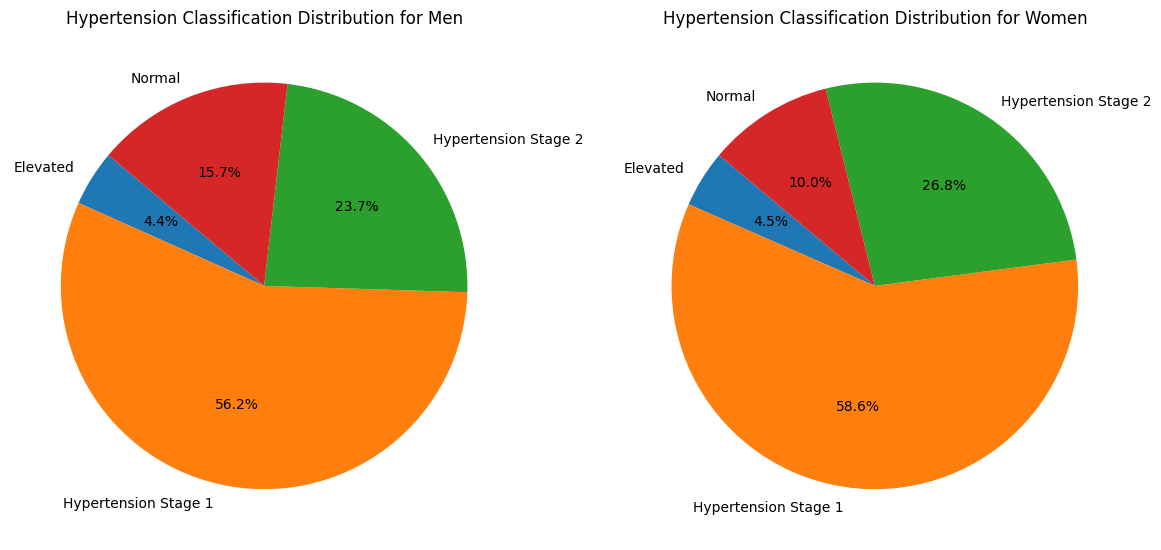

In [31]:
#drawing pie charts for knowing which gender is having more hypertension
hypertension_counts = df.groupby(['gender', 'Hypertension']).size().unstack()
plt.figure(figsize=(12, 6))

for i, gender in enumerate(hypertension_counts.index):
    gender_label = "Women" if gender == 2 else "Men"
    plt.subplot(1, 2, i + 1)
    plt.pie(hypertension_counts.loc[gender], labels=hypertension_counts.columns, autopct='%1.1f%%', startangle=140)
    plt.title(f'Hypertension Classification Distribution for {gender_label}')

plt.tight_layout()
plt.show()